## Comparaison de performances entre mp3 et wav

In [1]:
from pydub import AudioSegment
import numpy as np

def load_from_wav(filePath,sr):
    audio = AudioSegment.from_wav(filePath)
    audio = audio.set_frame_rate(sr)
    audio = audio.set_channels(1)  # mono
    arr = np.array(audio.get_array_of_samples(), dtype=float)
    return arr,sr

def load_from_mp3(filePath,sr):
    audio = AudioSegment.from_file(filePath)
    audio = audio.set_frame_rate(sr)
    audio = audio.set_channels(1)  # mono
    arr = np.array(audio.get_array_of_samples(), dtype=float)
    return(arr,sr)


In [59]:
import numpy as np
import librosa
import audiofile
import scipy.signal as sps
def load_audiosegment(filePath,sr):
    audio = AudioSegment.from_wav(filePath)
    audio = audio.set_channels(1).set_frame_rate(sr)
    arr = np.array(audio.get_array_of_samples(), dtype=float)
    audio.export("poto.wav", format="wav")
    return arr,sr

load_audiosegment("./sounds/yes_1675445508552.wav",16000)
audio, fs = audiofile.read("poto.wav")
print(fs)


def load_audiofile(filePath,sr):
    audio, fs = audiofile.read(filePath)
    dec_factor = fs//sr
    audio = sps.decimate(audio, dec_factor)
    arr = np.array(audio, dtype=float)
    audiofile.write("poto2.wav", audio, sr)
    return arr,sr

load_audiofile("./sounds/yes_1675445508552.wav",16000)
audio, fs = audiofile.read("poto2.wav")
print(fs)

def load_librosa(filePath,sr):
    audio,sr = librosa.load(filePath,sr=sr)
    arr = np.array(audio, dtype=float)
    audiofile.write("poto3.wav", audio, sr)
    return arr,sr


load_librosa("./sounds/yes_1675445508552.wav",16000)
audio, fs = audiofile.read("poto3.wav")
print(fs)

16000
16000
16000


In [57]:
import timeit

time1 = timeit.timeit("load_audiosegment('./common_voice_en_21895918.wav',44000)",
                      setup="from __main__ import load_audiosegment", number=20)
time2 = timeit.timeit("load_audiofile('./common_voice_en_21895918.wav',44000)", setup="from __main__ import load_audiofile", number=20)
time3 = timeit.timeit("load_librosa('./common_voice_en_21895918.wav',44000)", setup="from __main__ import load_librosa", number=20)

print("pydub audiosegment : ",time1)
print("audiofile : ",time2)
print("librosa : ",time3)

pydub audiosegment :  0.335361000001285
audiofile :  0.6955480999986321
librosa :  7.326318600000377


Audiosegment est performant et gère mieux le resampling

#  Generate MFCC function


In [12]:
from pydub import AudioSegment
import numpy as np

def load_from_wav(filePath):
    audio,sr = librosa.load(filePath)
    arr = np.array(audio, dtype=float)
    return arr,sr

In [3]:
import os
import pandas as pd
import pickle
import librosa

def generate_mfcc(tsv_filepath,src_audio_path,target_filepath,n_mels=20, n_mfcc=13):
    X = []
    y1 = []
    df = pd.read_csv(tsv_filepath, delimiter='\t')
    for index, row in df.iterrows():
        y, sr = load_from_wav(src_audio_path+row["path"]+".wav",16000)
        S = librosa.power_to_db(
            librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels))
        mfcc = librosa.feature.mfcc(S=S, n_mfcc=n_mfcc)
        X.append(mfcc)
        y1.append(row["sentence"])
    with open(target_filepath,"wb") as f:
        pickle.dump(X,f)
        pickle.dump(y1,f)
    return X, y1



#  Generate different MFCC from common voice

In [ ]:

n_mels_list = [20]
n_mfcc_list = [5,7,9,11]

def generate_mfcc_multiple(tsv_filepath,src_audio_path,target_filepath,n_mels_list, n_mfcc_list):
    X = np.empty((len(n_mels_list),len(n_mfcc_list)),dtype=object)
    y1 = np.zeros((len(n_mels_list),len(n_mfcc_list)),dtype=object)
    tuples = np.empty((len(n_mels_list),len(n_mfcc_list)),dtype=object)
    df = pd.read_csv(tsv_filepath, delimiter='\t')
    i,j = 0,0
    for n_mels in n_mels_list:
        j=0
        for n_mfcc in n_mfcc_list:
            tuples[i][j] = (n_mels,n_mfcc)
            X[i][j] = []
            y1[i][j] = []
            j += 1
        i += 1

    for index, row in df.iterrows():
        i,j = 0,0
        for n_mels in n_mels_list:
            j=0
            for n_mfcc in n_mfcc_list:
                tuples[i][j] = (n_mels,n_mfcc)
                y, sr = load_from_wav(src_audio_path+row["path"]+".wav",16000)
                S = librosa.power_to_db(
                    librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels))
                mfcc = librosa.feature.mfcc(S=S, n_mfcc=n_mfcc)
                X[i][j].append(mfcc)
                y1[i][j].append(row["sentence"])
                j += 1
            i += 1

    i,j = 0,0
    for n_mels in n_mels_list:
        j=0
        for n_mfcc in n_mfcc_list:
            with open(target_filepath+"_"+str(n_mels)+"mels_"+str(n_mfcc)+"mfcc.pkl","wb") as f:
                pickle.dump(X[i][j],f)
                pickle.dump(y1[i][j],f)
            j += 1
        i += 1 
    return X, y1

generate_mfcc_multiple("../utils/tsv_files/simple_validated.tsv","../../data/common_voice/","../assets/MFCCs/16k_train",n_mels_list,n_mfcc_list)


# for n_mels in n_mels_list:
#     for n_mfcc in n_mfcc_list:
#         generate_mfcc("../utils/tsv_files/simple_validated.tsv","../../data/common_voice/","../assets/MFCCs/16k_"+str(n_mels)+"mels_"+str(n_mfcc)+"mfcc.pkl",n_mels,n_mfcc)
#         print("generated "+str(n_mels)+"mels_"+str(n_mfcc)+"mfcc.pkl")

In [21]:
n_mels_list = [20]
n_mfcc_list = [5,7,9,11]

def generate_mfcc_multiple(tsv_filepath,src_audio_path,target_filepath,n_mels_list, n_mfcc_list):
    df = pd.read_csv(tsv_filepath, delimiter='\t')
        
    audios = []
    for index, row in df.iterrows():
        print(index)
        audios.append(load_from_wav(src_audio_path+row["path"]+".wav"))
    with open(target_filepath+"_audios.pkl", "wb") as f:
        pickle.dump(audios, f)
    # audios = pickle.load(open("../assets/MFCCs/16k_train_audios.pkl","rb"))

    for n_mels in n_mels_list:
        j=0
        for n_mfcc in n_mfcc_list:
            print("starting : "+str(n_mels)+"mels_"+str(n_mfcc)+"mfcc.pkl")

            X = []
            y1 = []
            for index, row in df.iterrows():
                y = audios[index][0]
                S = librosa.power_to_db(
                    librosa.feature.melspectrogram(y=y, sr=audios[index][1], n_mels=n_mels))
                mfcc = librosa.feature.mfcc(S=S, n_mfcc=n_mfcc)
                X.append(mfcc)
                y1.append(row["sentence"])
            with open(target_filepath+"_"+str(n_mels)+"mels_"+str(n_mfcc)+"mfcc.pkl", "wb") as f:
                pickle.dump(X, f)
                pickle.dump(y1, f)
    return X, y1

generate_mfcc_multiple("../utils/tsv_files/simple_validated.tsv","../../data/common_voice/","../assets/MFCCs/16k_train",n_mels_list,n_mfcc_list)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

([array([[-2.85714011e+02, -2.85714011e+02, -2.85714011e+02, ...,
          -1.17194917e+02, -1.16830757e+02, -1.27099562e+02],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           5.80699568e+01,  5.72651793e+01,  5.58661843e+01],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          -1.05861748e+01, -1.18813825e+01, -1.28915862e+01],
         ...,
         [-7.27122929e-15, -7.27122929e-15, -7.27122929e-15, ...,
           3.11962996e+00,  4.05698416e+00,  2.08538251e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           1.88893089e-01,  9.81694201e-01,  3.56921916e-01],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          -7.91530348e-01,  9.19355290e-01,  7.20220327e-01]]),
  array([[-2.85394251e+02, -2.28196151e+02, -1.83646293e+02,
          -1.73059580e+02, -1.79986301e+02, -1.86412854e+02,
          -1.92809621e+02, -1.99112956e+02, -2.05126247e+02,
          -2.07921522e+02, -2.056

# Generate a specific MFCC

In [23]:
audios = pickle.load(open("../assets/MFCCs/16k_train_audios.pkl","rb"))


In [1]:
S = librosa.power_to_db(
    librosa.feature.melspectrogram(y=audios[5000][0], sr=audios[5000][1], n_mels=20))
mfcc = librosa.feature.mfcc(S=S, n_mfcc=5)
mfcc


NameError: name 'librosa' is not defined

In [ ]:
n_mels = 20
n_mfcc = 5

generate_mfcc("../utils/tsv_files/simple_validated_augmented.tsv","../../data/common_voice/","../assets/MFCCs/validated_augmented16k"+str(n_mels)+"mels_"+str(n_mfcc)+"mfcc.pkl",n_mels,n_mfcc)


In [ ]:
generate_mfcc("./sounds/rahim/rahim.tsv","./sounds/rahim/","../assets/MFCCs/rahim_mfcc.pkl",20,5)


([array([[ 5.41076859e+01,  7.21973253e+01,  7.57460183e+01,
           7.26224419e+01,  5.97554279e+01,  4.63572478e+01,
           3.57969571e+01,  3.78191102e+01,  4.02543315e+01,
           3.61024358e+01,  3.36490013e+01,  3.47015201e+01,
           3.76368541e+01,  4.06103234e+01,  4.04356234e+01,
           3.99951902e+01,  3.52028483e+01,  3.81069569e+01,
           3.68313879e+01,  3.24724140e+01,  3.03714078e+01,
           3.33709284e+01,  4.46128319e+01,  4.23815521e+01,
           3.67783292e+01,  3.69115143e+01,  3.84152915e+01,
           3.67349580e+01,  8.94507488e+01,  1.40263339e+02,
           1.64458510e+02,  1.67780809e+02,  1.61345825e+02,
           1.78051968e+02,  2.05507982e+02,  2.23455588e+02,
           2.33244439e+02,  2.39422942e+02,  2.44464701e+02,
           2.47246609e+02,  2.49344694e+02,  2.51119916e+02,
           2.50222116e+02,  2.47690329e+02,  2.46449161e+02,
           2.43943795e+02,  2.37378273e+02,  2.30315427e+02,
           2.23527733e+0

### Graphiques (hyperparameters...)

In [ ]:

import matplotlib.pyplot as plt
for i in range(len(hist)):
    # plt.plot(hist[i].history["accuracy"])
    plt.plot(hist[i].history["val_accuracy"])
plt.legend(['Adam', 'RMSprop', 'SGD'], loc='upper left')
plt.title("model accuracy")
plt.ylabel("validation accuracy")
plt.xlabel("epoch")
# plt.legend(["train", "test"], loc="upper left")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

def LSTM_train_model(X_train, y_train, epoch, batch_size, validation_split, num_classes, optimizers, n_mfcc=13):
    histories = []
    for optimizer in optimizers:
        model = Sequential()
        model.add(LSTM(128, input_shape=(n_mfcc, max_length)))
        model.add(Dense(num_classes, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        history = model.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, validation_split = validation_split, use_multiprocessing=True)
        histories.append(history)

    for i in range(len(histories)):
        plt.plot(histories[i].history["val_accuracy"])
    plt.legend(optimizers, loc='upper left')
    plt.title("model accuracy")
    plt.ylabel("validation accuracy")
    plt.xlabel("epoch")
    plt.show()


In [ ]:
optimizers = ["Adadelta", "Adagrad", "Adam", "Adamax", "Ftrl", "Nadam", "RMSprop", "SGD"]
LSTM_train_model(X_train, y_train, epoch = 20, batch_size = 96, validation_split = 0.05, num_classes = num_classes, optimizers = optimizers, n_mfcc=13)

Epoch 1/20
124/124 [==============================] - 23s 137ms/step - loss: 1.8853 - accuracy: 0.1597 - val_loss: 1.8862 - val_accuracy: 0.1613
Epoch 2/20
124/124 [==============================] - 10s 78ms/step - loss: 1.8828 - accuracy: 0.1611 - val_loss: 1.8840 - val_accuracy: 0.1597
Epoch 3/20
124/124 [==============================] - 8s 68ms/step - loss: 1.8805 - accuracy: 0.1616 - val_loss: 1.8821 - val_accuracy: 0.1613
Epoch 4/20
124/124 [==============================] - 9s 75ms/step - loss: 1.8783 - accuracy: 0.1621 - val_loss: 1.8802 - val_accuracy: 0.1613
Epoch 5/20
124/124 [==============================] - 9s 74ms/step - loss: 1.8763 - accuracy: 0.1630 - val_loss: 1.8784 - val_accuracy: 0.1645
Epoch 6/20
124/124 [==============================] - 9s 70ms/step - loss: 1.8743 - accuracy: 0.1642 - val_loss: 1.8767 - val_accuracy: 0.1661
Epoch 7/20
124/124 [==============================] - 8s 67ms/step - loss: 1.8723 - accuracy: 0.1650 - val_loss: 1.8749 - val_accuracy: 0.1

ValueError: Unknown optimizer: 'Optimizer'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

Epoch 1/20
118/118 [==============================] - 16s 88ms/step - loss: 1.8818 - accuracy: 0.1696 - val_loss: 1.8662 - val_accuracy: 0.1775
Epoch 2/20
118/118 [==============================] - 9s 74ms/step - loss: 1.8795 - accuracy: 0.1702 - val_loss: 1.8644 - val_accuracy: 0.1775
Epoch 3/20
118/118 [==============================] - 9s 73ms/step - loss: 1.8775 - accuracy: 0.1711 - val_loss: 1.8628 - val_accuracy: 0.1783
Epoch 4/20
118/118 [==============================] - 9s 80ms/step - loss: 1.8755 - accuracy: 0.1714 - val_loss: 1.8613 - val_accuracy: 0.1799
Epoch 5/20
118/118 [==============================] - 15s 124ms/step - loss: 1.8737 - accuracy: 0.1720 - val_loss: 1.8598 - val_accuracy: 0.1815
Epoch 6/20
118/118 [==============================] - 10s 86ms/step - loss: 1.8719 - accuracy: 0.1725 - val_loss: 1.8584 - val_accuracy: 0.1831
Epoch 7/20
118/118 [==============================] - 10s 86ms/step - loss: 1.8702 - accuracy: 0.1736 - val_loss: 1.8571 - val_accuracy: 0

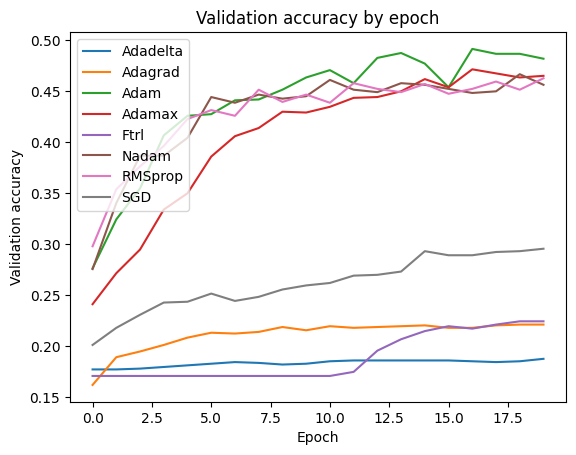

In [ ]:
import matplotlib.pyplot as plt

n_mfcc=13
optimizers = ["Adadelta", "Adagrad", "Adam", "Adamax", "Ftrl", "Nadam", "RMSprop", "SGD"]
histories = []
for optimizer in optimizers:
    model = Sequential()
    model.add(LSTM(128, input_shape=(n_mfcc, max_length)))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer, metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=20, batch_size=96, validation_split=0.1, use_multiprocessing=True)
    histories.append(history)
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print("Test accuracy of model with {} optimizer: {:.4f}".format(optimizer, test_acc))

plt.figure()
for i in range(len(histories)):
    plt.plot(histories[i].history["val_accuracy"])
plt.legend(optimizers, loc='upper left')
plt.title("Validation accuracy by epoch")
plt.ylabel("Validation accuracy")
plt.xlabel("Epoch")
plt.show()
# This code will plot the validation accuracy of each model during each epoch, as well as print the accuracy of X_test for each optimizer after training the models.






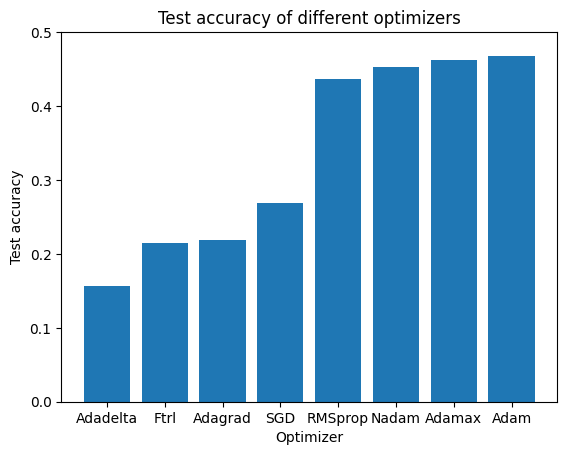

In [ ]:
test_accuracies = ["0.1567","0.2193","0.4673","0.4623","0.2150","0.4522","0.4371","0.2682"]
optimizers = ["Adadelta", "Adagrad", "Adam", "Adamax", "Ftrl", "Nadam", "RMSprop", "SGD"]

# Convert the test_accuracies to float
test_accuracies = [float(acc) for acc in test_accuracies]

# Zip the optimizers and test_accuracies together and sort the list of tuples based on the test_accuracies
optimizers_and_accuracies = sorted(zip(optimizers, test_accuracies), key=lambda x: x[1])

# Unzip the sorted list of tuples
optimizers, test_accuracies = zip(*optimizers_and_accuracies)

plt.bar(optimizers, test_accuracies)
plt.title("Test accuracy of different optimizers")
plt.xlabel("Optimizer")
plt.ylabel("Test accuracy")
plt.ylim(0, 0.5)
# plt.yticks(sorted(test_accuracies))
plt.show()

### Fonction entrainement modèle, cacul accuracy, plot validation accuracy by epoch and test accuracy for different hyperparameters

In [ ]:
import matplotlib.pyplot as plt

def LSTM_train_model_plot(X_train, y_train, epoch, batch_size, validation_split, num_classes, optimizers, n_mfcc=13):
    histories = []
    test_accuracies = []
    for optimizer in optimizers:
        model = Sequential()
        model.add(LSTM(128, input_shape=(n_mfcc, max_length)))
        model.add(Dense(num_classes, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        history = model.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, validation_split = validation_split, use_multiprocessing=True)
        histories.append(history)
        test_loss, test_acc = model.evaluate(X_test, y_test)
        print("Test accuracy of model with {} optimizer: {:.4f}".format(optimizer, test_acc))
        test_accuracies.append(test_acc)
        


    for i in range(len(histories)):
        plt.plot(histories[i].history["val_accuracy"])
    plt.legend(optimizers, loc='upper left')
    plt.title("model accuracy")
    plt.ylabel("validation accuracy")
    plt.xlabel("epoch")
    plt.show()

    # plt.bar(optimizers, test_accuracies)
    # plt.title("Test accuracy of different optimizers")
    # plt.xlabel("Optimizer")
    # plt.ylabel("Test accuracy")
    # plt.show()
    
    return histories, test_accuracies
    

### On va tester pour Adam avec des learning_rates différents

Epoch 1/20
124/124 [==============================] - 19s 94ms/step - loss: 1.7563 - accuracy: 0.2427 - val_loss: 1.7039 - val_accuracy: 0.2748
Epoch 2/20
124/124 [==============================] - 10s 81ms/step - loss: 1.5048 - accuracy: 0.4125 - val_loss: 1.5995 - val_accuracy: 0.3562
Epoch 3/20
124/124 [==============================] - 10s 80ms/step - loss: 1.2947 - accuracy: 0.5229 - val_loss: 1.5341 - val_accuracy: 0.3754
Epoch 4/20
124/124 [==============================] - 10s 81ms/step - loss: 1.1028 - accuracy: 0.6056 - val_loss: 1.5017 - val_accuracy: 0.4010
Epoch 5/20
124/124 [==============================] - 10s 80ms/step - loss: 0.9389 - accuracy: 0.6791 - val_loss: 1.5321 - val_accuracy: 0.4169
Epoch 6/20
124/124 [==============================] - 10s 80ms/step - loss: 0.7981 - accuracy: 0.7327 - val_loss: 1.6007 - val_accuracy: 0.4042
Epoch 7/20
124/124 [==============================] - 10s 78ms/step - loss: 0.6802 - accuracy: 0.7840 - val_loss: 1.6015 - val_accuracy:

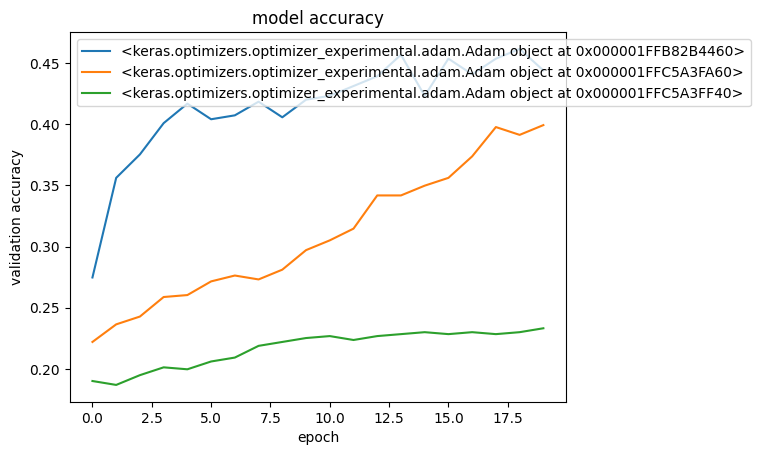

TypeError: cannot unpack non-iterable NoneType object

In [ ]:
optimizers = []
# optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)

learning_rates = [1e-3, 1e-4, 1e-5]
for learning_rate in learning_rates:
    optimizers.append(tf.keras.optimizers.Adam(learning_rate))

histories, test_accuracies = LSTM_train_model_plot(X_train, y_train, epoch = 20, batch_size = 96, validation_split = 0.05, num_classes = num_classes, optimizers = optimizers, n_mfcc=13)



### Allons plus loin avec learning_rate = 1e-5 (on va prendre davantage d'epoch du coup)

Epoch 1/80
124/124 [==============================] - 31s 75ms/step - loss: 1.8669 - accuracy: 0.1687 - val_loss: 1.8884 - val_accuracy: 0.1693
Epoch 2/80
124/124 [==============================] - 9s 71ms/step - loss: 1.8498 - accuracy: 0.1772 - val_loss: 1.8772 - val_accuracy: 0.1629
Epoch 3/80
124/124 [==============================] - 8s 68ms/step - loss: 1.8352 - accuracy: 0.1853 - val_loss: 1.8677 - val_accuracy: 0.1613
Epoch 4/80
124/124 [==============================] - 7s 57ms/step - loss: 1.8222 - accuracy: 0.1928 - val_loss: 1.8601 - val_accuracy: 0.1645
Epoch 5/80
124/124 [==============================] - 7s 57ms/step - loss: 1.8105 - accuracy: 0.1982 - val_loss: 1.8531 - val_accuracy: 0.1661
Epoch 6/80
124/124 [==============================] - 7s 56ms/step - loss: 1.7997 - accuracy: 0.2056 - val_loss: 1.8467 - val_accuracy: 0.1821
Epoch 7/80
124/124 [==============================] - 7s 55ms/step - loss: 1.7898 - accuracy: 0.2112 - val_loss: 1.8409 - val_accuracy: 0.182

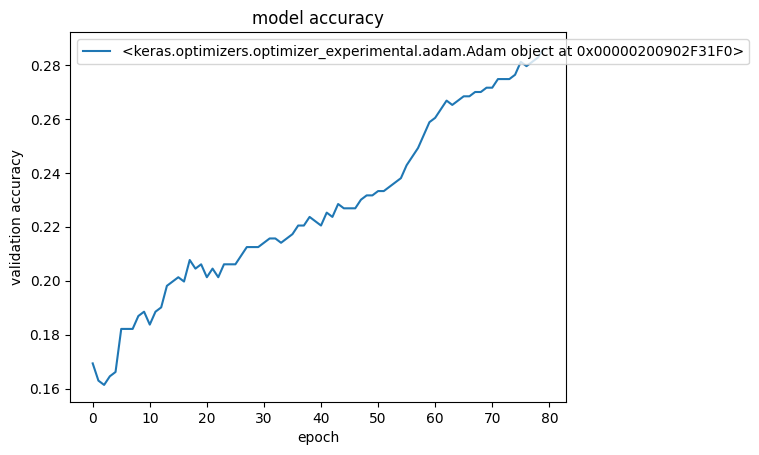

TypeError: the dtypes of parameters x (object) and width (float64) are incompatible

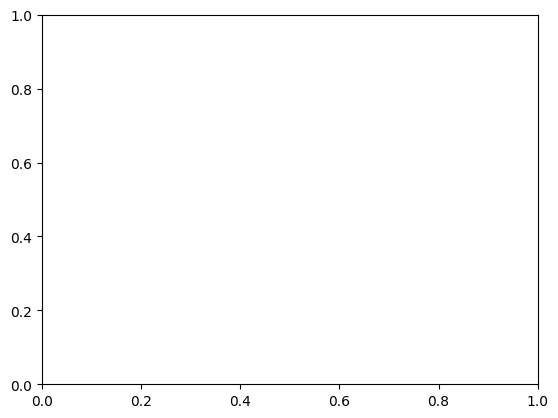

In [ ]:
optimizers = []
# optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)

learning_rates = [1e-5]
for learning_rate in learning_rates:
    optimizers.append(tf.keras.optimizers.Adam(learning_rate))

histories, test_accuracies = LSTM_train_model_plot(X_train, y_train, epoch = 80, batch_size = 96, validation_split = 0.05, num_classes = num_classes, optimizers = optimizers, n_mfcc=13)



### Essayons d'aller plus loin avec learning_rates 1e-4 déjà, au moins aller jusqu'à la stabilisation

Epoch 1/80
124/124 [==============================] - 17s 87ms/step - loss: 1.8159 - accuracy: 0.1961 - val_loss: 1.7779 - val_accuracy: 0.2236
Epoch 2/80
124/124 [==============================] - 10s 80ms/step - loss: 1.7309 - accuracy: 0.2578 - val_loss: 1.7499 - val_accuracy: 0.2524
Epoch 3/80
124/124 [==============================] - 10s 83ms/step - loss: 1.6745 - accuracy: 0.2981 - val_loss: 1.7283 - val_accuracy: 0.2556
Epoch 4/80
124/124 [==============================] - 9s 76ms/step - loss: 1.6273 - accuracy: 0.3362 - val_loss: 1.7108 - val_accuracy: 0.2780
Epoch 5/80
124/124 [==============================] - 14s 112ms/step - loss: 1.5841 - accuracy: 0.3719 - val_loss: 1.6947 - val_accuracy: 0.2875
Epoch 6/80
124/124 [==============================] - 16s 128ms/step - loss: 1.5423 - accuracy: 0.4022 - val_loss: 1.6768 - val_accuracy: 0.3083
Epoch 7/80
124/124 [==============================] - 14s 114ms/step - loss: 1.5007 - accuracy: 0.4325 - val_loss: 1.6609 - val_accurac

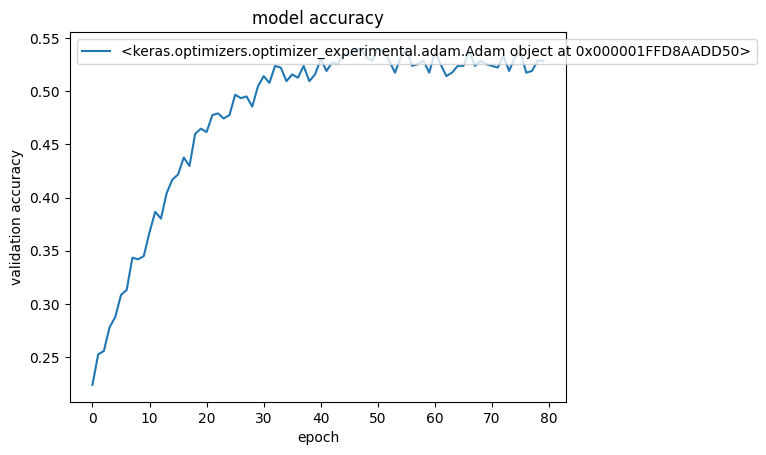

In [ ]:
optimizers = []
# optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)

learning_rates = [1e-4]
for learning_rate in learning_rates:
    optimizers.append(tf.keras.optimizers.Adam(learning_rate))

histories, test_accuracies = LSTM_train_model_plot(X_train, y_train, epoch = 80, batch_size = 96, validation_split = 0.05, num_classes = num_classes, optimizers = optimizers, n_mfcc=13)


### Y a du progèrs et stabilisation vers 52% pour val_accuracy et test_accuracy 
Testons avec learning_rate=e-5 et epochs =300
On peut utiliser "initial_epoch"

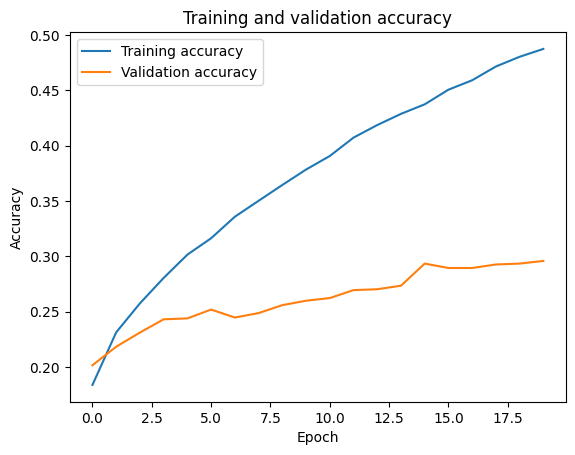

In [ ]:
#test avec initial_epoch, juste 1 epoch à partir du précédent model
# test_loss, test_acc = history.evaluate(X_test, y_test)
# print("Test accuracy of model with: ", test_acc)
# history
# history = history(X_train, y_train, epoch = 1, batch_size = 96, validation_split = 0.05, num_classes = num_classes, optimizers = optimizers, initial_epoch=20, n_mfcc=13)
# print(history.history['accuracy'])

# import matplotlib.pyplot as plt

# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# plt.plot(acc, label='Training accuracy')
# plt.plot(val_acc, label='Validation accuracy')
# plt.legend()
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Training and validation accuracy')
# plt.show()


Epoch 1/300
124/124 [==============================] - 30s 116ms/step - loss: 1.8804 - accuracy: 0.1659 - val_loss: 1.8651 - val_accuracy: 0.1629
Epoch 2/300
124/124 [==============================] - 7s 57ms/step - loss: 1.8585 - accuracy: 0.1739 - val_loss: 1.8499 - val_accuracy: 0.1693
Epoch 3/300
124/124 [==============================] - 7s 57ms/step - loss: 1.8411 - accuracy: 0.1808 - val_loss: 1.8387 - val_accuracy: 0.1709
Epoch 4/300
124/124 [==============================] - 7s 54ms/step - loss: 1.8264 - accuracy: 0.1880 - val_loss: 1.8300 - val_accuracy: 0.1757
Epoch 5/300
124/124 [==============================] - 7s 56ms/step - loss: 1.8136 - accuracy: 0.1961 - val_loss: 1.8226 - val_accuracy: 0.1789
Epoch 6/300
124/124 [==============================] - 7s 57ms/step - loss: 1.8021 - accuracy: 0.2025 - val_loss: 1.8163 - val_accuracy: 0.1837
Epoch 7/300
124/124 [==============================] - 7s 55ms/step - loss: 1.7917 - accuracy: 0.2129 - val_loss: 1.8114 - val_accurac

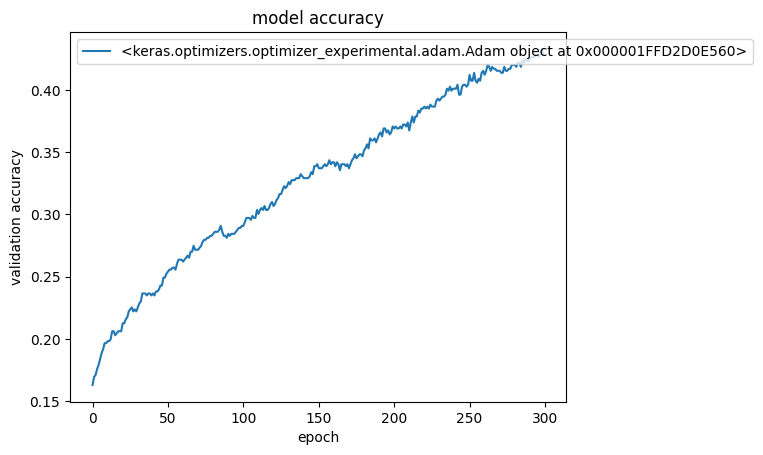

In [ ]:
optimizers = []

learning_rates = [1e-5]
for learning_rate in learning_rates:
    optimizers.append(tf.keras.optimizers.Adam(learning_rate))

histories, test_accuracies = LSTM_train_model_plot(X_train, y_train, epoch = 300, batch_size = 96, validation_split = 0.05, num_classes = num_classes, optimizers = optimizers, n_mfcc=13)


In [ ]:
test_accuracies


[0.4421279728412628]